<a href="https://colab.research.google.com/github/sunfflur/frequency-learning/blob/master/kylberg-texture-dataset/Exp_02_a_ResNet50V2_varyingdatasize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet50V2

#### Libraries Import

In [ ]:
s = 23
import os
os.environ['PYTHONHASHSEED']=str(s)
import random
random.seed(s)
from numpy.random import seed
seed(s)
from tensorflow.random import set_seed
set_seed(s)

import PIL
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Conv1D, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

!pip install tensorflow-addons 
!pip install tensorflow-recommenders

import tensorflow_addons as tfa
import tensorflow_recommenders as tfrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 12.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 6.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May  3 01:09:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    50W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


#### Drive mount

In [ ]:
### TESSSSSST ###

!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 122523 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


#### Data Load

In [ ]:
### data loading ### 
path_train = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_train.npy'
path_ytrain = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_y_train.npy'
path_test = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_test.npy'
path_ytest = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_y_test.npy'

x_train, x_test = np.load(path_train), np.load(path_test)
y_train, y_test = np.load(path_ytrain), np.load(path_ytest)
x_train, x_test = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1), x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# adjust dimension and change from array to tensor + convert to 3 channel images
new_shape = (224,224)
x_train, x_test = tf.image.resize(x_train, new_shape), tf.image.resize(x_test, new_shape)
x_train, x_test = tf.image.grayscale_to_rgb(x_train), tf.image.grayscale_to_rgb(x_test)
y_train, y_test = tf.stack(to_categorical(y_train)), tf.stack(to_categorical(y_test))

In [ ]:
x_train.shape

TensorShape([3360, 224, 224, 3])

#### Pre-trained model

In [ ]:
# prepare the image for the ResNet50 model
x_train1 = preprocess_input(x_train)
x_test1 = preprocess_input(x_test)

In [ ]:
def pre_trained_model(input_shape, n_classes, optimizer, fine_tune=0):
    """
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training.
    fine_tune: int - The number of pre-trained layers to unfreeze. 
               0 = all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    resnet50_model = ResNet50V2(include_top=True,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    
    if fine_tune > 0:
        for layer in resnet50_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in resnet50_model.layers:
            layer.trainable = False
    '''
    for layer in resnet50_model.layers:
      layer.trainable = True
    '''
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = resnet50_model.layers[-2].output
    #top_model = Flatten(name="flatten")(top_model)
    #top_model = Dense(4096, activation='relu')(top_model)
    #top_model = Dense(128, activation='relu')(top_model)
    #top_model = Dropout(0.25)(top_model)
    output_layer = Dense(n_classes, activation='softmax', name='my_predictions')(top_model)
    
    # Group the convolutional base and new output into a Model object.
    model = Model(inputs=resnet50_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
tf.random.set_seed(s) #s
opt = Adam(learning_rate=0.0001)
ResNet50_model = pre_trained_model(input_shape=(224,224,3), n_classes=28, optimizer=opt)

102869336/102869336 [==============================] - 0s 0us/step


In [ ]:
print(ResNet50_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# ModelCheckpoint callback - save best weights
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-pynb/model_resnet50v2_pt.weights.best.hdf5', save_best_only=True, verbose=0)
history = ResNet50_model.fit(x_train1, y_train, epochs=100, batch_size=16, verbose=1, shuffle=True, validation_split=0.1, callbacks=[checkpoint, estopping])

Epoch 1/100
189/189 [==============================] - 26s 82ms/step - loss: 2.5088 - accuracy: 0.3770 - val_loss: 1.4942 - val_accuracy: 0.7976
Epoch 2/100
189/189 [==============================] - 13s 67ms/step - loss: 1.0123 - accuracy: 0.9130 - val_loss: 0.7226 - val_accuracy: 0.9851
Epoch 3/100
189/189 [==============================] - 13s 67ms/step - loss: 0.5459 - accuracy: 0.9769 - val_loss: 0.4416 - val_accuracy: 0.9970
Epoch 4/100
189/189 [==============================] - 13s 67ms/step - loss: 0.3613 - accuracy: 0.9854 - val_loss: 0.3080 - val_accuracy: 1.0000
Epoch 5/100
189/189 [==============================] - 13s 67ms/step - loss: 0.2649 - accuracy: 0.9901 - val_loss: 0.2311 - val_accuracy: 1.0000
Epoch 6/100
189/189 [==============================] - 13s 70ms/step - loss: 0.2064 - accuracy: 0.9914 - val_loss: 0.1812 - val_accuracy: 1.0000
Epoch 7/100
189/189 [==============================] - 13s 69ms/step - loss: 0.1670 - accuracy: 0.9921 - val_loss: 0.1469 - val_ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


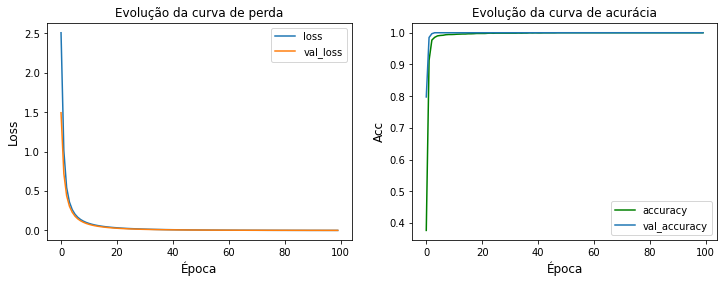

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.subplot(121), plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.subplot(122), plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
ResNet50_model.load_weights('/content/drive/MyDrive/Mestrado/Experimentos/exp8 - ALOT/exp8-pynb/model_resnet50v2_pt.weights.best.hdf5')

In [ ]:
### TEST ACC ###
scores = ResNet50_model.evaluate(x_test1, y_test)
print('\n%s : %.2f%%' % (ResNet50_model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 5s 88ms/step - loss: 0.0042 - accuracy: 0.9991

accuracy : 99.91%


#### Random Initialization

In [ ]:
# prepare the image for the ResNet50 model
x_train1 = preprocess_input(x_train)
x_test1 = preprocess_input(x_test)
del x_train
del x_test

In [ ]:
def non_pre_trained_model(input_shape, n_classes, optimizer, fine_tune=0):
    """
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training.
    fine_tune: int - The number of pre-trained layers to unfreeze. 
               0 = all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    resnet50_model = ResNet50V2(include_top=True,
                     weights=None, 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    '''
    if fine_tune > 0:
        for layer in resnet50_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in resnet50_model.layers:
            layer.trainable = False
    '''
    for layer in resnet50_model.layers:
      layer.trainable = True
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = resnet50_model.layers[-2].output
    #top_model = Flatten(name="flatten")(top_model)
    #top_model = Dense(4096, activation='relu')(top_model)
    #top_model = Dense(128, activation='relu')(top_model)
    #top_model = Dropout(0.25)(top_model)
    output_layer = Dense(n_classes, activation='softmax', name='my_predictions')(top_model)
    
    # Group the convolutional base and new output into a Model object.
    model = Model(inputs=resnet50_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
tf.random.set_seed(s) #s
opt = Adam(learning_rate=0.0001)
ResNet50_model = non_pre_trained_model(input_shape=(224,224,3), n_classes=28, optimizer=opt)

In [ ]:
print(ResNet50_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# ModelCheckpoint callback - save best weights
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-pynb/model_resnet50v2_rdn.weights.best.hdf5', save_best_only=True, verbose=0)
history = ResNet50_model.fit(x_train1, y_train, epochs=100, batch_size=16, verbose=1, shuffle=True, validation_split=0.1, callbacks=[checkpoint, estopping])

Epoch 1/100
189/189 [==============================] - 47s 213ms/step - loss: 1.5654 - accuracy: 0.5093 - val_loss: 16.3921 - val_accuracy: 0.0387
Epoch 2/100
189/189 [==============================] - 37s 195ms/step - loss: 0.4502 - accuracy: 0.8578 - val_loss: 12.2461 - val_accuracy: 0.0774
Epoch 3/100
189/189 [==============================] - 38s 199ms/step - loss: 0.2841 - accuracy: 0.9041 - val_loss: 3.7168 - val_accuracy: 0.3839
Epoch 4/100
189/189 [==============================] - 37s 194ms/step - loss: 0.1986 - accuracy: 0.9388 - val_loss: 0.4878 - val_accuracy: 0.8393
Epoch 5/100
189/189 [==============================] - 31s 164ms/step - loss: 0.1319 - accuracy: 0.9570 - val_loss: 0.7338 - val_accuracy: 0.7708
Epoch 6/100
189/189 [==============================] - 31s 164ms/step - loss: 0.1050 - accuracy: 0.9656 - val_loss: 0.6473 - val_accuracy: 0.7708
Epoch 7/100
189/189 [==============================] - 31s 164ms/step - loss: 0.1171 - accuracy: 0.9656 - val_loss: 0.8031

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


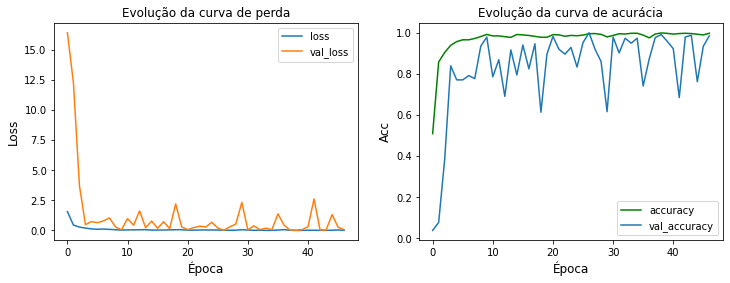

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.subplot(121), plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.subplot(122), plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
ResNet50_model.load_weights('/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-pynb/model_resnet50v2_rdn.weights.best.hdf5')

In [ ]:
### TEST ACC ###
scores = ResNet50_model.evaluate(x_test1, y_test)
print('\n%s : %.2f%%' % (ResNet50_model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 4s 90ms/step - loss: 0.0721 - accuracy: 0.9777

accuracy : 97.77%


##### VARYING DATA SIZE

In [ ]:
acc=[]
percents = [0.1, 0.25, 0.5, 0.75, 1.00]
for i in percents:
  tf.keras.backend.clear_session()
  print("Execucao {}".format(i))
  tf.random.set_seed(s) #s
  opt = Adam(learning_rate=0.0001)
  def split(x,y, test_size):
    x_train, x_test2, y_train, y_test2 = train_test_split(np.asarray(x), np.asarray(y), test_size=test_size, stratify=y)
    del x_train
    del y_train
    return x_test2, y_test2
  def non_pre_trained_model(input_shape, n_classes, optimizer, fine_tune=0):
    """
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training.
    fine_tune: int - The number of pre-trained layers to unfreeze. 
               0 = all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    resnet50_model = ResNet50V2(include_top=True,
                     weights=None, 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    '''
    if fine_tune > 0:
        for layer in resnet50_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in resnet50_model.layers:
            layer.trainable = False
    '''
    for layer in resnet50_model.layers:
      layer.trainable = True
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = resnet50_model.layers[-2].output
    #top_model = Flatten(name="flatten")(top_model)
    #top_model = Dense(4096, activation='relu')(top_model)
    #top_model = Dense(128, activation='relu')(top_model)
    #top_model = Dropout(0.25)(top_model)
    output_layer = Dense(n_classes, activation='softmax', name='my_predictions')(top_model)
    
    # Group the convolutional base and new output into a Model object.
    model = Model(inputs=resnet50_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model
  ResNet50_model = non_pre_trained_model(input_shape=(224,224,3), n_classes=28, optimizer=opt)
  if i !=1.00:
    print('<1')
    input_half, y_train_half = split(x_train1,y_train, i)
  else:
    print("Dataset Completo")
    input_half,y_train_half = x_train1,y_train
  # ModelCheckpoint callback - save best weights
  estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
  #checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-pynb/model_efficientnetv2s_pt.weights.best.hdf5', save_best_only=True, verbose=0)
  history = ResNet50_model.fit(input_half, y_train_half, epochs=100, batch_size=16, verbose=0, shuffle=True, validation_split=0.1, callbacks=[estopping]) #checkpoint, 
  scores = ResNet50_model.evaluate(x_test1, y_test)
  print('\n%s : %.2f%%' % (ResNet50_model.metrics_names[1], scores[1] * 100))
  acc.append(scores[1])
  del input_half
  del y_train_half
  del ResNet50_model
np.savetxt('/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-pynb/acc_exp2_asoc_ResNetV2.txt', acc)

Execucao 0.1
<1
35/35 [==============================] - 1s 17ms/step - loss: 7.5580 - accuracy: 0.0509

accuracy : 5.09%
Execucao 0.25
<1
35/35 [==============================] - 1s 17ms/step - loss: 0.3659 - accuracy: 0.8830

accuracy : 88.30%
Execucao 0.5
<1
35/35 [==============================] - 1s 17ms/step - loss: 0.8199 - accuracy: 0.7625

accuracy : 76.25%
Execucao 0.75
<1
35/35 [==============================] - 1s 17ms/step - loss: 0.0705 - accuracy: 0.9795

accuracy : 97.95%
Execucao 1.0
Dataset Completo
35/35 [==============================] - 1s 17ms/step - loss: 0.0466 - accuracy: 0.9848

accuracy : 98.48%
